In [43]:
import numpy as np
from numpy import random
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
from scipy import interpolate
import sys 
from re import search
from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude
import shutil
from keras.callbacks import CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import glob
from datetime import datetime
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from keras.layers.convolutional import MaxPooling1D
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten,LSTM
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
from pandas import DataFrame
from tensorflow import keras
from tensorflow.keras import layers
from focal_loss import BinaryFocalLoss

In [44]:
pathON="C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/interpo_ONOFF/ON_data/"
pathOFF="C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/interpo_ONOFF/OFF_data/"

In [45]:
#Storing in a list the adresses of all the data files in the notebook

data_files_ON=[]
file_names_ON=[]

data_files_OFF=[]
file_names_OFF=[]
data_files_ALL=[]
file_names_ALL=[]

#Storing in a list the adresses of all the data files in the notebook
for filename in os.listdir(pathOFF):
    f = os.path.join(pathOFF,filename)
    if os.path.isfile(f):
        data_files_OFF.append(f)
        file_names_OFF.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)
for filename in os.listdir(pathON):
    f = os.path.join(pathON,filename)
    if os.path.isfile(f):
        data_files_ON.append(f)
        file_names_ON.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)       

In [46]:
#Using data_files with only the 36 binning
Filter=True
binning=37


if Filter==True:
    
    idx_OFF=[]
    idx_ON=[]
    dataON=[]
    dataOFF=[]
    for i in range(len(data_files_OFF)):
        dataframe = pd.read_csv(data_files_OFF[i])
        lg = len(dataframe)
        
        if lg==binning:
            idx_OFF.append(i)
    
    for i in range(len(data_files_ON)):
        dataframe = pd.read_csv(data_files_ON[i])
        lg = len(dataframe)
#         print(lg)
        if lg==binning:
            idx_ON.append(i)

    #Construct csv dataframe with features of LC and LC dir
    # RA, DEC ,class, file name 

    #Future input shape : 3511 sources, 2 features (as time series) , x binnings
    for i in range(len(idx_OFF)):

        a=idx_OFF[i]
        dataOFF.append(data_files_OFF[a])
    for i in range(len(idx_ON)):

        a=idx_ON[i]
        dataON.append(data_files_ON[a])

idx = idx_OFF+idx_ON


In [9]:
#3D shape of data, multivariate time series

lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF
Class_ON = []
Class_OFF=[]

nbfeatures=3

a=binning
b=nbfeatures
c=lg

# multivariate
y=np.zeros((2,lg))
bigdata= np.zeros((b,c,a))


for j in range(len(dataOFF)):

    dataframe=pd.read_csv(dataOFF[j])
    dataframe.columns=['Iteration','MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']

    bigdata[0][j]=dataframe['Flux']
    bigdata[1][j]=dataframe['Photon Index']*dataframe['Flux']
    bigdata[2][j]=dataframe['Photon Index']


for j in range(len(dataON)):

    v=j+len(dataOFF)
    dataframe=pd.read_csv(dataON[j])
    dataframe.columns=['Iteration','MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']

    bigdata[0][v]=dataframe['Flux']

    bigdata[1][v]=dataframe['Photon Index']*dataframe['Flux']

    bigdata[2][v]=dataframe['Photon Index']

    



for i in range(lgOFF):
    
    Class_ON.append(int(0))
    
for i in range(lgON):
    a=lgOFF+i
    Class_ON.append(int(1))




In [10]:
bigdata=bigdata.reshape(c,binning,nbfeatures)
n_classes=2

In [11]:
model_history2="C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/interpo_ONOFF/history_transformers.csv"
csv_logger = CSVLogger(model_history2, append=True)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(bigdata, Class_ON, test_size=0.01, random_state=28)
y_test2=y_test.copy()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [13]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [14]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [16]:
input_shape = x_train.shape[1:]
weight_for_0 = (1 / lgOFF) * (lg / 2.0)
weight_for_1 = (1 / lgON) * (lg / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.2,
    dropout=0.1,)

model.compile(
    loss='binary_crossentropy',
#     loss=BinaryFocalLoss(gamma=5),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["binary_accuracy"],
    
    
)


callbacks = [keras.callbacks.EarlyStopping(patience=180, restore_best_weights=True),csv_logger]

model.fit(
    x_train,
    y_train,
    validation_split=0.25,
    epochs=20,
    batch_size=1,
    callbacks=callbacks,
    class_weight=class_weight
)



Epoch 1/20
727/727 [==============================] - 15s 13ms/step - loss: 0.5204 - binary_accuracy: 0.6740 - val_loss: 0.3510 - val_binary_accuracy: 0.6996
Epoch 2/20
727/727 [==============================] - 9s 12ms/step - loss: 0.3701 - binary_accuracy: 0.7483 - val_loss: 0.3540 - val_binary_accuracy: 0.7037
Epoch 3/20
727/727 [==============================] - 9s 12ms/step - loss: 0.3698 - binary_accuracy: 0.7730 - val_loss: 0.4746 - val_binary_accuracy: 0.6708
Epoch 4/20
727/727 [==============================] - 9s 12ms/step - loss: 0.3163 - binary_accuracy: 0.7442 - val_loss: 0.4088 - val_binary_accuracy: 0.6914
Epoch 5/20
727/727 [==============================] - 9s 12ms/step - loss: 0.3079 - binary_accuracy: 0.7813 - val_loss: 0.2907 - val_binary_accuracy: 0.8189
Epoch 6/20
727/727 [==============================] - 9s 12ms/step - loss: 0.3222 - binary_accuracy: 0.8377 - val_loss: 0.4025 - val_binary_accuracy: 0.7325
Epoch 7/20
727/727 [==============================] - 9s 

In [ ]:
# model.evaluate(x_test, y_test, verbose=1)

In [17]:
pred_train= model.predict(x_train)
scores = model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(100*scores[1], (1 - scores[1])*100)   )
 
pred_test= model.predict(x_test)
scores2 = model.evaluate(x_test,y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(100*scores2[1], (1 - scores2[1])*100) )

31/31 [==============================] - 5s 123ms/step
Accuracy on training data: 86.28866076469421% 
 Error on training data: 13.711339235305786
1/1 [==============================] - 0s 63ms/step
Accuracy on test data: 80.0000011920929% 
 Error on test data: 19.999998807907104


In [18]:
predicted_labels=[]
for i in range(len(pred_test)):
    if pred_test[i][0]>0.5:
        predicted_labels.append(0)
    else:
        predicted_labels.append(1)
print("Predicted Labels: ", predicted_labels)
print("Real      Labels: ",y_test2)

Predicted Labels:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Real      Labels:  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [ ]:
history = np.genfromtxt(model_history2,delimiter=',',names=True)

plt.plot(history["epoch"],history['loss'],label="training")
plt.plot(history["epoch"],history['val_loss'],label="validation")
plt.legend()
plt.show()

In [ ]:

# more stable v3 ! 

# model = build_model(
#     input_shape,
#     head_size=10,
#     num_heads=4,
#     ff_dim=2,
#     num_transformer_blocks=6,
#     mlp_units=[128],
#     mlp_dropout=0.2,
#     dropout=0.1,

# more stable v2 ! 

# model = build_model(
#     input_shape,
#     head_size=10,
#     num_heads=4,
#     ff_dim=2,
#     num_transformer_blocks=8,
#     mlp_units=[128],
#     mlp_dropout=0.2,
#     dropout=0.1,
# )

#     model.fit(
#     x_train,
#     y_train,
#     validation_split=0.3,
#     epochs=250,
#     batch_size=4,

In [47]:

lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF
Class_ON = []
Class_OFF=[]

nbfeatures=4

a=binning
b=nbfeatures
c=1

# multivariate
y=np.zeros((2,lg))
bigdata= np.zeros((b,a))
bigdata2= np.zeros((b,a))


dataframe=pd.read_csv(dataON[0])
dataframe.columns=['Iteration','MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']

bigdata[0]=dataframe['Flux']
bigdata[1]=dataframe['Photon Index']*dataframe['Flux']
bigdata[2]=dataframe['Photon Index']
bigdata[3]=dataframe['MJD']

dataframe=pd.read_csv(dataOFF[0])
dataframe.columns=['Iteration','MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']

bigdata2[0]=dataframe['Flux']
bigdata2[1]=dataframe['Photon Index']*dataframe['Flux']
bigdata2[2]=dataframe['Photon Index']
bigdata2[3]=dataframe['MJD']

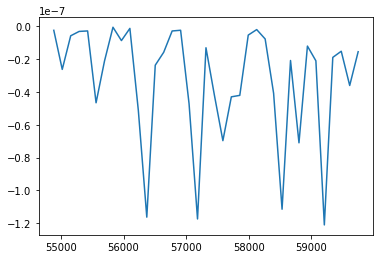

In [48]:
plt.plot(bigdata[3],bigdata[1])

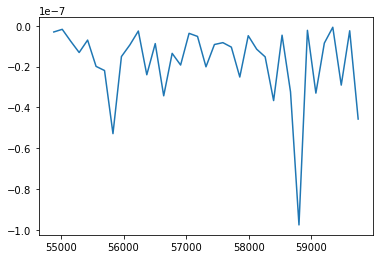

In [49]:
plt.plot(bigdata2[3],bigdata2[1])

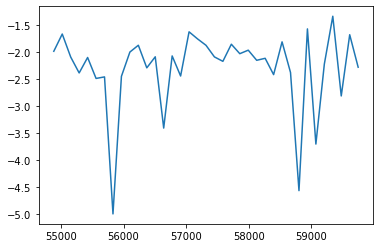

In [50]:
plt.plot(bigdata2[3],bigdata2[2])

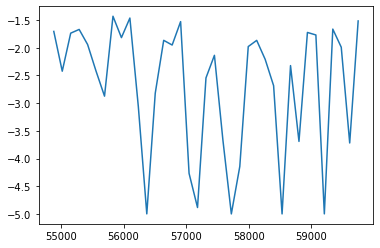

In [51]:
plt.plot(bigdata[3],bigdata[2])